# CNN Sınıflandırma – Model 1 (Transfer Learning)

Ad: Yusuf

Soyad: TUNÇ

Okul No: 2012721024

GitHub Repo Bağlantısı: https://github.com/ytunc4141/CNN_siniflandirma


Bu modelde VGG16 mimarisi, ImageNet ağırlıkları kullanılarak
transfer learning kapsamında eğitilmiştir.


## Gerekli Kütüphanelerin Yüklenmesi

Bu bölümde modelin kurulması, eğitilmesi ve değerlendirilmesi için gerekli olan `TensorFlow`, `Keras`, `NumPy` ve `Matplotlib` kütüphaneleri içe aktarılmıştır.

Ayrıca bu hücrede kullanılan `seed` değeri, model eğitimi sırasında oluşabilecek rastgelelikleri
kontrol altına almak ve sonuçların tekrar edilebilir olmasını sağlamak amacıyla eklenmiştir.


In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import random

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

## Google Drive Bağlantısı

Veri seti ve model çıktıları Google Drive üzerinde tutulduğu için Drive bağlantısı yapılmıştır.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Veri Seti ve Model Parametreleri

Bu bölümde veri setinin bulunduğu klasör yolu tanımlanmış, görüntü boyutu, batch size ve epoch sayısı gibi temel eğitim parametreleri belirlenmiştir.


In [3]:
DATASET_PATH = "/content/drive/MyDrive/Colab_Notebooks/CNN_Siniflandirma/dataset"

In [4]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 16
EPOCHS = 20

### Veri Ön İşleme (ImageDataGenerator)

Bu hücrede görüntüler modele verilmeden önce normalize edilmiştir.
Ayrıca `validation_split` parametresi kullanılarak veri seti
eğitim (%80) ve doğrulama (%20) olarak ikiye ayrılmıştır.

Eğitim verisi için küçük dönüşümler (döndürme, kaydırma, parlaklık değişimi vb.)
uygulanarak veri çeşitliliği artırılmıştır.
Bu sayede modelin farklı koşullara karşı daha dayanıklı öğrenmesi amaçlanmıştır.


In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    brightness_range=[0.7, 1.3]
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

### Eğitim ve Doğrulama Verilerinin Oluşturulması

Bu bölümde eğitim ve doğrulama verileri,
`ImageDataGenerator` ve `flow_from_directory` fonksiyonları kullanılarak
diskten okunmuş ve modele uygun hale getirilmiştir.

Görüntüler `target_size` parametresi ile belirlenen boyuta yeniden
ölçeklendirilmiş, sınıf etiketleri klasör isimlerine göre otomatik olarak
atanmıştır.

`validation_split` kullanılarak veri seti eğitim ve doğrulama olarak
ikiye ayrılmıştır.


In [6]:
train_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = val_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)


Found 119 images belonging to 2 classes.
Found 28 images belonging to 2 classes.


## VGG16 Modelinin Yüklenmesi (Transfer Learning)

Bu hücrede ImageNet veri seti üzerinde eğitilmiş VGG16 modeli, son katmanları hariç olacak şekilde yüklenmiştir.
Bu sayede önceden öğrenilmiş özelliklerden faydalanılmıştır.


In [7]:
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(128,128,3)
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Özel Sınıflandırma Katmanları

VGG16 taban modelinin üzerine `Flatten` , `Dense` ve `Dropout` katmanları eklenerek problemimize uygun bir sınıflandırma yapısı oluşturulmuştur.


In [8]:
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

## Modelin Derlenmesi

Model, `categorical_crossentropy` kayıp fonksiyonu ve `Adam` optimizasyon algoritması kullanılarak derlenmiştir.
Performans metriği olarak doğruluk `(accuracy)` seçilmiştir.


In [9]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,763,650 (60.13 MB)

 Trainable params: 15,763,650 (60.13 MB)

 Non-trainable params: 0 (0.00 B)

## Callback Yapıları

Eğitim sırasında en iyi doğrulama doğruluğuna sahip modelin kaydedilmesi için `ModelCheckpoint` kullanılmıştır.
Ayrıca aşırı öğrenmeyi önlemek amacıyla `EarlyStopping` uygulanmıştır.


In [10]:
checkpoint = ModelCheckpoint(
    "/content/drive/MyDrive/Colab_Notebooks/CNN_Siniflandirma/best_model_model1.h5",
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

## Modelin Eğitilmesi

Bu hücrede model, eğitim verileri üzerinde eğitilmiş ve doğrulama verileri ile performansı takip edilmiştir.


In [11]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[checkpoint, early_stop]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4587 - loss: 2.1632
Epoch 1: val_accuracy improved from -inf to 0.64286, saving model to /content/drive/MyDrive/Colab_Notebooks/CNN_Siniflandirma/best_model_model1.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 68s 6s/step - accuracy: 0.4628 - loss: 2.1210 - val_accuracy: 0.6429 - val_loss: 0.6428
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.5935 - loss: 0.6739
Epoch 2: val_accuracy did not improve from 0.64286
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 200ms/step - accuracy: 0.5929 - loss: 0.6706 - val_accuracy: 0.3929 - val_loss: 1.0749
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.8563 - loss: 0.3256
Epoch 3: val_accuracy improved from 0.64286 to 0.82143, saving model to /content/drive/MyDrive/Colab_Notebooks/CNN_Siniflandirma/best_model_model1.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 288ms/step - accuracy: 0.8657 - loss: 0.3091 - val_accuracy: 0.8214 - val_loss: 0.2731
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.9568 - loss: 0.3370
Epoch 4: val_accuracy did not improve from 0.82143
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 200ms/step - accuracy: 0.9579 - loss: 0.3315 - val_accuracy: 0.6429 - val_loss: 1.3854
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.8702 - loss: 0.3645
Epoch 5: val_accuracy improved from 0.82143 to 1.00000, saving model to /content/drive/MyDrive/Colab_Notebooks/CNN_Siniflandirma/best_model_model1.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 336ms/step - accuracy: 0.8753 - loss: 0.3549 - val_accuracy: 1.0000 - val_loss: 0.0481
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.9891 - loss: 0.0287
Epoch 6: val_accuracy did not improve from 1.00000
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 203ms/step - accuracy: 0.9893 - loss: 0.0282 - val_accuracy: 1.0000 - val_loss: 0.0019
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.9989 - loss: 0.0145
Epoch 7: val_accuracy did not improve from 1.00000
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 221ms/step - accuracy: 0.9981 - loss: 0.0195 - val_accuracy: 1.0000 - val_loss: 9.5233e-06
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 1.0000 - loss: 0.0016
Epoch 8: val_accuracy did not improve from 1.00000
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 229ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 9/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 1.0000 - loss: 2.9006e-05
Epoch 9: val_accuracy did not improve f

### Eğitim ve Doğrulama Doğruluk / Kayıp Grafikleri

Bu bölümde modelin eğitim süreci boyunca elde ettiği
eğitim ve doğrulama doğruluk `(accuracy)` ile kayıp `(loss)`
değerleri görselleştirilmiştir.

Grafikler sayesinde:
- Modelin öğrenme süreci,
- Aşırı öğrenme `(overfitting)` olup olmadığı,
- Eğitim ve doğrulama performansları arasındaki fark

incelenebilmektedir.


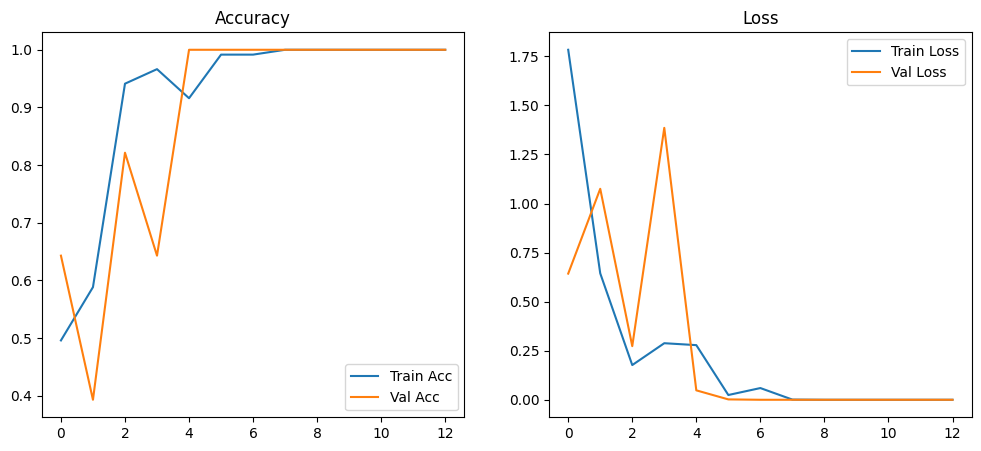

In [12]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.show()

### Modelin Doğrulama Verisi Üzerinde Değerlendirilmesi

Bu hücrede eğitilmiş model, doğrulama `(validation)` verisi üzerinde değerlendirilmiştir.  
Modelin doğruluk `(accuracy)` değeri hesaplanarak performansı ölçülmüştür.


In [13]:
val_loss, val_acc = model.evaluate(val_generator)
print(f"Test Accuracy: %{val_acc*100:.2f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Test Accuracy: %100.00


## En İyi Modelin Yüklenmesi

Eğitim sırasında kaydedilen en iyi model yüklenerek test verisi üzerinde değerlendirme yapılmıştır.


In [14]:
best_model = load_model(
    "/content/drive/MyDrive/Colab_Notebooks/CNN_Siniflandirma/best_model_model1.h5"
)
loss, acc = best_model.evaluate(val_generator)
print(f"Test Accuracy: %{acc*100:.2f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 532ms/step - accuracy: 1.0000 - loss: 0.0461
Test Accuracy: %100.00


## Tek Görüntü Üzerinde Tahmin

Bu bölümde eğitilmiş model kullanılarak tek bir trafik levhası görüntüsü üzerinde sınıf tahmini yapılmıştır.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


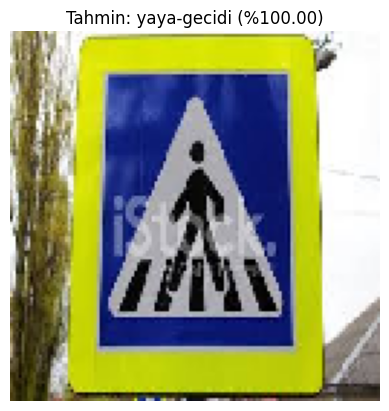

In [21]:
class_labels = {v: k for k, v in train_generator.class_indices.items()}

img_path = "/content/drive/MyDrive/Colab_Notebooks/CNN_Siniflandirma/test/5.jpg"

img = image.load_img(img_path, target_size=(128, 128))
img_array = image.img_to_array(img)
img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)

prediction = best_model.predict(img_array)
class_index = np.argmax(prediction)
predicted_class = class_labels[class_index]
confidence = np.max(prediction) * 100

plt.imshow(img)
plt.axis("off")
plt.title(f"Tahmin: {predicted_class} (%{confidence:.2f})")
plt.show()